In [45]:
from __future__ import division

import re
import math
import nltk
import string
import random
import codecs
import numpy as np
import itertools as it
import tensorflow as tf
import cPickle as pickle
import scipy.sparse as ss
import matplotlib.pyplot as plt
import tensorflow.contrib.seq2seq as seq2seq

from tqdm import tqdm
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow.contrib.layers import safe_embedding_lookup_sparse
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple, GRUCell
from tensorflow.python.layers import core as layers_core

In [46]:
def load_corpus(file_path):
    """ Load corpus from text file and tokenize """
    corpus = []
    vocab_cnt = Counter()
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    
    with codecs.open(file_path, 'r', encoding='utf-8') as fd:
        for line in fd:
            # clean lines from any punctuation characters
            clean_line = re.sub('[\+\-\.\,\:\;\"\?\!\>\<\=\(\)\n]+', '', line)
            tokens = tokenizer.tokenize(clean_line.lower())
            corpus.append(tokens)
            vocab_cnt.update(tokens)
            
    return corpus, vocab_cnt


def code_tokens(vocab_cnt, max_size=30000, unk_symbol='<unk>'):
    """ Filter vocabulary and encode tokens """
    vocab = ['<pad>', '<sos>', '<eos>', '<unk>']
    vocab.extend([word for word, _ in vocab_cnt.most_common(max_size)])
    vocab_enc = {token: ix for ix, token in enumerate(vocab)}
    vocab_dec = {ix: token for token, ix in vocab_enc.iteritems()}
    
    return vocab, vocab_enc, vocab_dec


def generate_context_data(corpus, max_window_size=5, skip_size=1, flatten=True):
    """ Generate data with context in format (target, [contexts]) or (target, context) """
    for center_ix in xrange(max_window_size, len(corpus)-max_window_size, skip_size):
        # sample a window size for the given center word
        window_size = np.random.randint(max_window_size) + 1
        full_context = corpus[center_ix-window_size:center_ix] + corpus[center_ix+1: center_ix+window_size+1]
        
        if flatten:
            for context_ix in xrange(2*window_size):
                yield (corpus[center_ix], full_context[context_ix])
        else:
            yield(corpus[center_ix], full_context)


def pad_data(data_arr, append_pre=[], append_suf=[], max_length=None):
    data_arr = [append_pre + row + append_suf for row in data_arr]
    lengths = [len(row) for row in data_arr]
    max_len = max(lengths) if not max_length else max_length
    return np.array([row+[0]*(max_len-length) for row, length in zip(data_arr, lengths)]), lengths
    
                
def batchify_data(data_generator, batch_size):
    """ Split dataset (generator) into batches """
    if isinstance(data_generator, list):
        for ix in xrange(0, len(data_generator), batch_size):
            buff = data_generator[ix:ix+batch_size]
            yield buff
    else:
        while data_generator:
            buff = []
            for ix in xrange(0, batch_size):
                buff.append(next(data_generator))
            yield buff


def save_embeddings(embeddings_obj, file_name):
    """ Save word embeddings and helper structures """
    with open(file_name, 'wb') as fd:
        pickle.dump(embeddings_obj, fd)
    

def load_embeddings(file_name):
    """ Load word embeddings and helper structures """
    with open(file_name, 'r') as fd:
        embeddings_obj = pickle.load(fd)
    return embeddings_obj
    
    
def get_tsne_embeddings(embedding_matrix):
    """ Compute t-SNE representation of embeddings """
    tsne = TSNE(perplexity=25, n_components=2, init='pca', n_iter=5000)
    return tsne.fit_transform(embedding_matrix)


def get_pca_embeddings(embedding_matrix):
    """ Compute PCA representation of embeddings """
    pca = PCA(n_components=2)
    return pca.fit_transform(embedding_matrix)


def plot_embeddings(embeddings, words=[], words_cnt=500, method='pca', figsize=(8,8)):
    """ Plot subset of embeddings in 2D space using t-SNE or PCA """
    embedding_matrix = embeddings._embeddings
    vocab_dec = embeddings._vocab_dec
    vocab_enc = embeddings._vocab_enc
    
    # prepare data
    if not words:
        vocab_size = embedding_matrix.shape[0]
        ixs = range(vocab_size)
        random.shuffle(ixs)
        chosen_ixs = ixs[:words_cnt]
        labels = [vocab_dec[ix] for ix in chosen_ixs]
        word_vecs = embedding_matrix[chosen_ixs]
    else:
        labels = words
        chosen_ixs = [vocab_enc[word] for word in words]
        word_vecs = embedding_matrix[chosen_ixs]
        
    if method == 'tsne':
        low_dim_embeddings = get_tsne_embeddings(word_vecs)
    else:
        low_dim_embeddings = get_pca_embeddings(word_vecs)
        
    # plot reduced vectors
    plt.figure(figsize=figsize)
    
    for embedding, label in zip(low_dim_embeddings, labels):
        x, y = embedding[0], embedding[1]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), 
                     textcoords='offset points', ha='right', 
                     va='bottom')
    plt.yticks=[]
    plt.xticks=[]
    plt.grid()
    plt.show()
    

class Embeddings(object):
    """ Class wrapping word embeddings """
    def __init__(self, embedding_matrix, vocab_enc, vocab_dec):
        self._embeddings = embedding_matrix
        self._vocab_enc = vocab_enc
        self._vocab_dec = vocab_dec
    
    def find_embedding(self, word):
        """ Find embedding for a given word """
        if isinstance(word, str):
            word = self._vocab_enc[word]
        return self._embeddings[word]
    
    def find_neighbors(self, word, k=5, nearest=True, exclude=[], include_scores=False):
        """ Find neighboring words (semantic regularities) """
        word_ix = self._vocab_enc[word]
        exclude = exclude + [word_ix]
        
        # find neighbors
        word_emb = self._embeddings[word_ix]
        similarities = self._embeddings.dot(word_emb)
        similarities[exclude] = 0
        best_matches = np.argsort(similarities)
        trimmed_matches = best_matches[-k:][::-1] if nearest else best_matches[:k]
        return [(self._vocab_dec[word_ix], similarities[word_ix]) for word_ix in trimmed_matches]
    
    def find_analogous(self, word_a, word_b, word_c, k=5):
        """ Find analogous word (syntactic regularities: word_a - word_b = x - word_c) """
        word_a_ix, word_b_ix, word_c_ix = [self._vocab_enc[word] for word in [word_a, word_b, word_c]]
        exclude = [word_a_ix, word_b_ix, word_c_ix]
        
        emb_a = self.find_embedding(word_a_ix) 
        emb_b = self.find_embedding(word_b_ix) 
        emb_c = self.find_embedding(word_c_ix) 
        emb_d_hat = emb_a - emb_b + emb_c
        similarities = self._embeddings.dot(emb_d_hat)
        similarities[exclude] = 0
        best_matches = np.argsort(similarities)
        trimmed_matches = best_matches[-k:][::-1]
        return [(self._vocab_dec[word_ix], similarities[word_ix]) for word_ix in trimmed_matches]
    
    def vocab(self):
        """ Return vocabulary list """
        return self._vocab_enc.keys()

Corpus A size (total tokens): 44426895
Corpus A vocabulary size (distinct tokens): 393538
Most popular words (corpus A): [(u'die', 1987622), (u'der', 1713750), (u'und', 1341291), (u'in', 781954), (u'zu', 630396)]

Corpus B size (total tokens): 47714854
Corpus B vocabulary size (distinct tokens): 150175
Most popular words (corpus B): [(u'the', 3668124), (u'of', 1739353), (u'to', 1615743), (u'and', 1376235), (u'in', 1136721)]


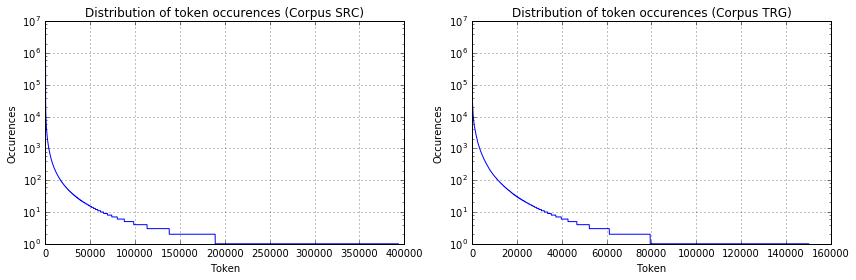

In [48]:
CORPUS_A_PATH, CORPUS_B_PATH = './corpora/europarl.de-en.de', './corpora/europarl.de-en.en'
#CORPUS_A_PATH, CORPUS_B_PATH = './corpora/europarl.pl-en.pl', './corpora/europarl.pl-en.en'

# LOAD CORPUS
corpus_a, vocab_cnt_a = load_corpus(CORPUS_A_PATH)
corpus_b, vocab_cnt_b = load_corpus(CORPUS_B_PATH)

raw_corpus_a_size = sum(vocab_cnt_a.itervalues())
raw_vocab_a_size = len(vocab_cnt_a)
raw_corpus_b_size = sum(vocab_cnt_b.itervalues())
raw_vocab_b_size = len(vocab_cnt_b)

print 'Corpus A size (total tokens):', raw_corpus_a_size
print 'Corpus A vocabulary size (distinct tokens):', raw_vocab_a_size
print 'Most popular words (corpus A):', vocab_cnt_a.most_common(5)
print
print 'Corpus B size (total tokens):', raw_corpus_b_size
print 'Corpus B vocabulary size (distinct tokens):', raw_vocab_b_size
print 'Most popular words (corpus B):', vocab_cnt_b.most_common(5)

# visualize distribution
counts_a = sorted(vocab_cnt_a.itervalues(), reverse=True)
counts_b = sorted(vocab_cnt_b.itervalues(), reverse=True)
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.semilogy(range(len(counts_a)), counts_a)
plt.title('Distribution of token occurences (Corpus SRC)')
plt.xlabel('Token')
plt.ylabel('Occurences')
plt.grid()
plt.subplot(122)
plt.semilogy(range(len(counts_b)), counts_b)
plt.title('Distribution of token occurences (Corpus TRG)')
plt.xlabel('Token')
plt.ylabel('Occurences')
plt.tight_layout()
plt.grid()
plt.show()

In [49]:
# LIMIT VOCABS
LANG_A_TOKEN_LIMIT = 45000
vocab_a, vocab_enc_a, vocab_dec_a = code_tokens(vocab_cnt_a, LANG_A_TOKEN_LIMIT)
corpus_a_enc = [[vocab_enc_a[word] for word in sentence if word in vocab_enc_a] for sentence in corpus_a]

LANG_B_TOKEN_LIMIT = 25000
vocab_b, vocab_enc_b, vocab_dec_b = code_tokens(vocab_cnt_b, LANG_B_TOKEN_LIMIT)
corpus_b_enc = [[vocab_enc_b[word] for word in sentence if word in vocab_enc_b] for sentence in corpus_b]

print 'Clean corpus A size (total sentences):', len(corpus_a_enc)
print 'Clean corpus A vocabulary size (distinct tokens):', len(vocab_a)
print
print 'Clean corpus B size (total sentences):', len(corpus_b_enc)
print 'Clean corpus B vocabulary size (distinct tokens):', len(vocab_b)

Clean corpus A size (total sentences): 1920209
Clean corpus A vocabulary size (distinct tokens): 45004

Clean corpus B size (total sentences): 1920209
Clean corpus B vocabulary size (distinct tokens): 25004


Max length diff: 269
Avg length diff: 0.00497966627591


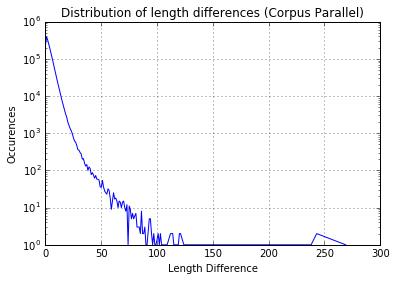

In [50]:
corpus_par = zip(corpus_a_enc, corpus_b_enc)
length_diff = Counter([abs(len(a) - len(b)) for a, b in corpus_par])

print 'Max length diff:', max(length_diff.keys())
print 'Avg length diff:', sum(length_diff.keys()) / len(corpus_par)


keys, values = zip(*sorted(length_diff.iteritems(), key=lambda x: x[0]))
plt.figure(figsize=(6, 4))
plt.semilogy(keys, values)
plt.title('Distribution of length differences (Corpus Parallel)')
plt.xlabel('Length Difference')
plt.ylabel('Occurences')
plt.grid()
plt.show()

In [42]:
VOCAB_SIZE_SRC = len(vocab_a)
VOCAB_SIZE_TRG = len(vocab_b)
BATCH_SIZE = 32

NUM_LAYERS = 1
EMB_SIZE = 150
ENC_HIDDEN_UNITS = 200
DEC_HIDDEN_UNITS = ENC_HIDDEN_UNITS
LEARNING_RATE = 0.001

# reset graph
tf.reset_default_graph()
sess = tf.InteractiveSession()

# define placeholders for data
with tf.variable_scope('placeholders') as scope:
    enc_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
    dec_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')
    dec_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
    
    enc_inputs_len = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_len')
    dec_inputs_len = tf.placeholder(shape=(None,), dtype=tf.int32, name='decoder_inputs_len')
    max_dec_inputs_len = tf.reduce_max(dec_inputs_len, name='max_decoder_inputs_len')

# define embeddings and lookup
with tf.variable_scope('embeddings') as scope:
    embeddings_src = tf.Variable(tf.random_uniform([VOCAB_SIZE_SRC, EMB_SIZE], -0.25, 0.25), dtype=tf.float32)
    embeddings_trg = tf.Variable(tf.random_uniform([VOCAB_SIZE_TRG, EMB_SIZE], -0.25, 0.25), dtype=tf.float32)
    enc_inputs_emb = tf.nn.embedding_lookup(embeddings_src, enc_inputs)
    dec_inputs_emb = tf.nn.embedding_lookup(embeddings_trg, dec_inputs)

# define encoder
with tf.variable_scope('encoder') as scope:
#     enc_cell = tf.contrib.rnn.MultiRNNCell(
#         [tf.contrib.rnn.GRUCell(ENC_HIDDEN_UNITS)] for _ in xrange(NUM_LAYERS))
    enc_cell = tf.contrib.rnn.LSTMCell(ENC_HIDDEN_UNITS)
    _, enc_final_state = tf.nn.dynamic_rnn(
        cell=enc_cell, 
        inputs=enc_inputs_emb, 
        sequence_length=enc_inputs_len, 
        time_major=False, 
        dtype=tf.float32, 
        scope='encoder_cell')
    
# define training decoder
with tf.variable_scope('decoder') as scope:
    dec_out_layer = layers_core.Dense(VOCAB_SIZE_TRG)
    dec_cell = tf.contrib.rnn.LSTMCell(DEC_HIDDEN_UNITS)
    
    dec_train_helper = tf.contrib.seq2seq.TrainingHelper(
        inputs=dec_inputs_emb,
        sequence_length=dec_inputs_len,
        time_major=False,
        name='trainig_helper')
    
    dec_train_decoder = seq2seq.BasicDecoder(
        cell=dec_cell,
        helper=dec_train_helper,
        initial_state=enc_final_state,
        output_layer=dec_out_layer)

    dec_train_outputs = seq2seq.dynamic_decode(
        decoder=dec_train_decoder,
        output_time_major=True,
        impute_finished=True,
        maximum_iterations=max_dec_inputs_len)[0]
    
    
with tf.variable_scope('decode', reuse=True) as scope:
    eos_slice = tf.fill([BATCH_SIZE], vocab_enc_a['<eos>'], name='EOS')
    
    dec_infer_helper = seq2seq.SampleEmbeddingHelper(
        embedding=embeddings_trg,
        start_tokens=eos_slice,
        end_token=2)
    
    dec_infer_decoder = seq2seq.BasicDecoder(
        cell=dec_cell,
        helper=dec_train_helper,
        initial_state=enc_final_state,
        output_layer=dec_out_layer)
    
    dec_infer_outputs = seq2seq.dynamic_decode(
        decoder=dec_infer_decoder,
        output_time_major=False,
        impute_finished=True,
        maximum_iterations=max_dec_inputs_len)[0]
    
    
with tf.variable_scope('optimization') as scope:
    dec_train_logits = tf.identity(dec_train_outputs.rnn_output)
    dec_infer_logits = tf.identity(dec_infer_outputs.rnn_output)
    dec_train_preds = dec_train_outputs.sample_id 
    dec_infer_preds = tf.argmax(dec_infer_logits, 2)
    
    masks = tf.sequence_mask(
        lengths=dec_inputs_len, 
        maxlen=max_dec_inputs_len,
        dtype=tf.float32, 
        name='masks')
    
    loss = seq2seq.sequence_loss(
        logits=dec_train_logits,
        targets=dec_targets,
        weights=masks,
        average_across_timesteps=True,
        average_across_batch=True)
    
    train_op = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

In [44]:
sess.run(tf.global_variables_initializer())

try:
    batch_ix = 0
    loss_track = []
    batches_gen = batchify_data(corpus_par, BATCH_SIZE)
    
    for batch_data in batches_gen: 
        # split batch
        batch_src, batch_trg = zip(*batch_data)
        
        # prepare batch
        enc_inp, enc_lengths = pad_data(batch_src, append_suf=[])
        dec_inp, _ = pad_data(batch_trg, append_pre=[2])
        dec_trg, dec_lengths = pad_data(batch_trg, append_suf=[2])
        
        # train
        fd = {
            enc_inputs: enc_inp,
            enc_inputs_len: enc_lengths,
            dec_inputs: dec_inp,
            dec_inputs_len: dec_lengths,
            dec_targets: dec_trg
        }
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch_ix == 0 or batch_ix % 25 == 0:
            print('batch {}'.format(batch_ix))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(dec_train_preds, fd)
            for i, (inp, pred) in enumerate(zip(fd[enc_inputs], predict_)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(' '.join([vocab_dec_a[word].encode('ascii', errors='replace') for word in inp])))
                print('    predicted > {}'.format(' '.join([vocab_dec_b[word].encode('ascii', errors='replace') for word in pred])))
                if i >= 2:
                    break
        batch_ix += 1
                    
except KeyboardInterrupt:
    print 'Training Interrupted'

batch 0
  minibatch loss: 9.30221939087
  sample 1:
    input     > dzia?ania podj?te w wyniku rezolucji parlamentu patrz protok?l <pad> <pad> <pad> <pad> <pad>
    predicted > headlined taken taken paths documents taken adopt actions fantastic plays varies documents taken taken taken documents fur amnesty fur available revised refuted council reiterating council herds council feed council amounting council bomb
  sample 2:
    input     > sk?adanie dokument?w patrz protok?? <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
    predicted > illegally taken stara antilaw umbrella umbrella child's cofinanced antarctic 3% prescribed reiterating taken taken umbrella posted rest skies fur amounting driven and freeze plays freeze savings awarded election freeze plays freeze mulder
  sample 3:
    input     > o?wiadczenia pisemne art 116 regulaminu patrz protok?? <pad> <pad> <pad> <pad> <pad> <pad>
    predicted > defences written stara embarking minds smallscale openended noe shut 3% eec 

## Toy examples

In [ ]:
def toy_data_generator(vocab_size, data_size, max_seq_length):
    for _ in xrange(data_size):
        seq_length = np.random.randint(max_seq_length)+1
        yield [np.random.randint(vocab_size-3)+3 for _ in xrange(seq_length)]

In [ ]:
# define constant parameters
DATA_SIZE = 500000
VOCAB_SIZE = 10
BATCH_SIZE = 32
MAX_SEQ_LENGTH = 5

EMB_SIZE = 20
ENC_HIDDEN_UNITS = 20
DEC_HIDDEN_UNITS = ENC_HIDDEN_UNITS

PAD = vocab_enc_a['<pad>']
SOS = vocab_enc_a['<sos>']
EOS = vocab_enc_a['<eos>']

# define model inputs
enc_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32)
dec_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32)
dec_targets = tf.placeholder(shape=(None, None), dtype=tf.int32)

# define embedding matrix and lookup embeddings
embeddings = tf.Variable(tf.random_uniform([VOCAB_SIZE, EMB_SIZE], -1.0, 1.0), dtype=tf.float32)
enc_inputs_emb = tf.nn.embedding_lookup(embeddings, enc_inputs)
dec_inputs_emb = tf.nn.embedding_lookup(embeddings, dec_inputs)

# define encoder
enc_cell = tf.contrib.rnn.GRUCell(ENC_HIDDEN_UNITS)
_, enc_final_state = tf.nn.dynamic_rnn(
    enc_cell, enc_inputs_emb, dtype=tf.float32, time_major=True, scope='encoder')

# define decoder
dec_cell = tf.contrib.rnn.GRUCell(DEC_HIDDEN_UNITS)
dec_outputs, dec_final_state = tf.nn.dynamic_rnn(
    dec_cell, dec_inputs_emb, initial_state=enc_final_state,
    dtype=tf.float32, time_major=True, scope='decoder')

# define output layer
dec_logits = tf.contrib.layers.linear(dec_outputs, VOCAB_SIZE)
dec_preds = tf.argmax(dec_logits, 2)

# define loss function and optimizer
step_centropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(dec_targets, depth=VOCAB_SIZE, dtype=tf.float32),
    logits=dec_logits)
loss = tf.reduce_mean(step_centropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [ ]:
sess.run(tf.global_variables_initializer())

try:
    batch_ix = 0
    loss_track = []
    batches_gen = batchify_data(toy_data_generator(VOCAB_SIZE, DATA_SIZE, MAX_SEQ_LENGTH), BATCH_SIZE)
    
    for data_batch in batches_gen: 
        enc_inc, lengths = pad_data(data_batch)
        enc_len = lengths
        dec_tar, _ = pad_data(data_batch, append_suf=[2, 0, 0])
        
        fd = {
            enc_inputs: enc_inc.T,
            enc_inputs_len: lengths,
            dec_targets: dec_tar.T
        }
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch_ix == 0 or batch_ix % 1000 == 0:
            print('batch {}'.format(batch_ix))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(dec_preds, fd)
            for i, (inp, pred) in enumerate(zip(fd[enc_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
        batch_ix += 1
                    
except KeyboardInterrupt:
    print 'Training Interrupted'

In [ ]:
# define constant parameters
VOCAB_SIZE_SRC = len(vocab_a)
VOCAB_SIZE_TRG = len(vocab_b)
BATCH_SIZE = 32
MAX_SEQ_LENGTH = 5

EMB_SIZE = 20
ENC_HIDDEN_UNITS = 20
DEC_HIDDEN_UNITS = ENC_HIDDEN_UNITS

# reset graph
tf.reset_default_graph()
sess = tf.InteractiveSession()

# define placeholders for data
enc_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
enc_inputs_len = tf.placeholder(shape=(None), dtype=tf.int32, name='encoder_inputs_len')
dec_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
dec_targets_len = tf.placeholder(shape=(None), dtype=tf.int32, name='decoder_targets_len')

# define embeddings and lookup
embeddings_src = tf.Variable(tf.random_uniform([VOCAB_SIZE_SRC, EMB_SIZE], -1.0, 1.0), dtype=tf.float32)
embeddings_trg = tf.Variable(tf.random_uniform([VOCAB_SIZE_TRG, EMB_SIZE], -1.0, 1.0), dtype=tf.float32)
enc_inputs_emb = tf.nn.embedding_lookup(embeddings_src, enc_inputs)

# define encoder
enc_cell = tf.contrib.rnn.GRUCell(ENC_HIDDEN_UNITS)
_, enc_final_state = tf.nn.dynamic_rnn(
    enc_cell, enc_inputs_emb, dtype=tf.float32, time_major=True, scope='encoder_cell')
# additional stuff must be done for attention

# define decoder
dec_cell = tf.contrib.rnn.GRUCell(DEC_HIDDEN_UNITS)
# dec_lengths = enc_inputs_len + 3

dec_smax_W = tf.Variable(tf.random_uniform([DEC_HIDDEN_UNITS, VOCAB_SIZE_TRG], -1.0, 1.0), dtype=tf.float32)
dec_smax_b = tf.Variable(tf.zeros([VOCAB_SIZE_TRG]), dtype=tf.float32)

eos_slice = tf.fill([BATCH_SIZE], vocab_enc_a['<eos>'], name='EOS')
pad_slice = tf.fill([BATCH_SIZE], vocab_enc_a['<pad>'], name='PAD')

eos_slice_emb = tf.nn.embedding_lookup(embeddings_src, eos_slice)
pad_slice_emb = tf.nn.embedding_lookup(embeddings_src, pad_slice)

# loop transition function (defines inputs of step t given outputs of step t-1)
# (time, prev_cell_output, prev_cell_state, prev_loop_state) -> (elements_finished, input, cell_state, output, loop_state)
def loop_fn(time, prev_output, prev_state, prev_loop_state):
    if prev_state is None:
        init_elements_finished = (0 >= dec_targets_len)
        init_input = eos_slice_emb
        init_cell_state = enc_final_state
        init_cell_output = None
        init_loop_state = None
        return (init_elements_finished, init_input, init_cell_state, init_cell_output, init_loop_state)
    else:
        def get_next_input():
            output_logits = tf.add(tf.matmul(prev_output, dec_smax_W), dec_smax_b)
            pred = tf.argmax(output_logits, axis=1)
            next_input = tf.nn.embedding_lookup(embeddings_trg, pred)
            return next_input

        step_elements_finished = (time >= dec_targets_len)
        step_finished = tf.reduce_all(step_elements_finished)
        step_input = tf.cond(step_finished, lambda: pad_slice_emb, get_next_input)
        step_state = prev_state
        step_output = prev_output
        step_loop_state = None
        return (step_elements_finished, step_input, step_state, step_output, step_loop_state)

dec_outputs_ta, dec_final_state, _ = tf.nn.raw_rnn(
    dec_cell, loop_fn)
dec_outputs = dec_outputs_ta.stack()

dec_max_steps, dec_batch_size, dec_dim = tf.unstack(tf.shape(dec_outputs))
dec_outputs_flat = tf.reshape(dec_outputs, (-1, dec_dim))
dec_logits_flat = tf.add(tf.matmul(dec_outputs_flat, dec_smax_W), dec_smax_b)
dec_logits = tf.reshape(dec_logits_flat, (dec_max_steps, dec_batch_size, VOCAB_SIZE_TRG))
dec_preds = tf.argmax(dec_logits, 2)

# define loss function and optimizer
stepwise_cent = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(dec_targets, depth=VOCAB_SIZE_TRG, dtype=tf.float32),
    logits=dec_logits)
loss = tf.reduce_mean(stepwise_cent)
train_op = tf.train.AdamOptimizer().minimize(loss)